# Assignment 3

20249071: Rajat Maindoliya

20259344: Imelda Butler

Does code execute to end? Y

In [50]:
%pip install gym    

import warnings
warnings.simplefilter(action = 'ignore')
import gym
import random
from IPython.display import clear_output 

Note: you may need to restart the kernel to use updated packages.


In [51]:
# Create an instance of the Mountain Car environment
env = gym.make('MountainCar-v0')


# Reset the environment and get the initial observation
env.reset()

(array([-0.5810655,  0.       ], dtype=float32), {})

In [52]:
# Print the state space and action space of the environment

print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


In [53]:
# Print the minimum possible values for each variable in the state space
print(env.observation_space.low)

# Print the maximum possible values for each variable in the state space
print(env.observation_space.high)

[-1.2  -0.07]
[0.6  0.07]


In [54]:
from IPython.display import HTML

# Define the table data
data = [
    ('State Variable', 'Quantity', 'Min', 'Max'),
    ('0', 'Car position', '-1.2', '0.6'),
    ('1', 'Car velocity', '-0.07', '0.07')
]

# Create the HTML table
html = "<table>"
html += "<tr>"
for header in data[0]:
    html += f"<th style='background-color: red; color: white; font-weight: bold; font-size: 18px; padding: 8px; border: 1px solid black;'>{header}</th>"
html += "</tr>"
for row in data[1:]:
    html += "<tr>"
    for cell in row:
        html += f"<td style='text-align: center; border: 1px solid black; padding: 8px;'>{cell}</td>"
    html += "</tr>"
html += "</table>"

# Display the table using HTML
HTML(html)

State Variable,Quantity,Min,Max
0,Car position,-1.2,0.6
1,Car velocity,-0.07,0.07


In [55]:
#prints the initial state of an environment using the reset() function.

print(env.reset())

(array([-0.45512876,  0.        ], dtype=float32), {})


In [56]:
# Take an action in the environment and observe the results
print(env.step(2))

(array([-0.4546387 ,  0.00049008], dtype=float32), -1.0, False, False, {})


In [64]:
# Import necessary libraries: NumPy, Gym, and Matplotlib.

import numpy as np
import gym
import matplotlib.pyplot as plt

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()

# Define Q-learning function
def QLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                        size = (num_states[0], num_states[1], 
                                env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low) * np.array([10, 100])
        state_adj = np.round(state_adj).astype(int)
    
        while done != True:   
            # Render environment for last five episodes
            if i >= (episodes - 20):
                env.render()
                
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                discount*np.max(Q[state2_adj[0], 
                                                state2_adj[1]]) - 
                                Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta

            # Update variables
            tot_reward += reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
    #Finally, the function returns the list of average rewards per episode.
    
    return ave_reward_list

In [66]:
state = torch.tensor([1, 2])  # Example tensor shape (1, 2)
env_low = env.observation_space.low
env_low_reshaped = torch.tensor(env_low).reshape(state.shape)

# Then, attempt the subtraction
difference = state - env_low_reshaped
print(difference)


print(state.shape)
print(state_adj.shape)
print(env.observation_space.low.shape)
rewards = QLearning(env, 0.2, 0.9, 0.8, 0, 1000)
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

tensor([2.2000, 2.0700])
torch.Size([2])
(2,)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [63]:
rewards = QLearning(env, 0.2, 0.9, 0.8, 0, 5000)
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
rewards = QLearning(env, 0.2, 0.9, 0.5, 0, 5000)
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

In [ ]:
rewards = QLearning(env, 0.2, 0.5, 0.8, 0, 5000)
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

Complete


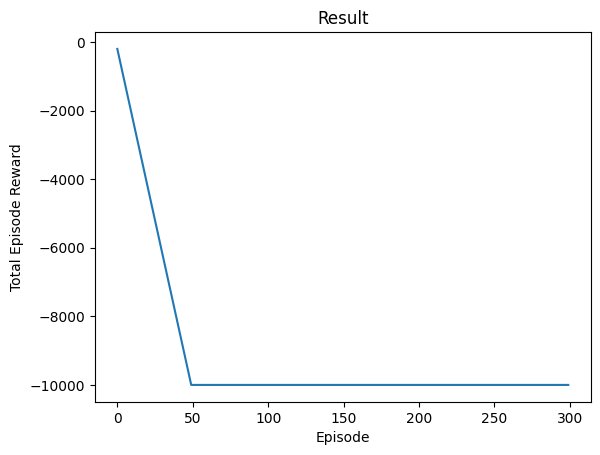

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
rewards = QLearning(env, 0.2, 0.1, 0.8, 0, 5000)
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')